In [0]:
# Cartopyをインストール
!apt install proj-bin libproj-dev libgeos-dev
!pip install shapely cartopy 

In [0]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# 日本語フォントをダウンロードする。
!apt-get -y install fonts-ipafont-gothic

# キャッシュを削除する。
!rm /root/.cache/matplotlib/fontList.json　# 旧cache
!rm /root/.cache/matplotlib/fontlist-v300.json # 消すべきcache

#ここでランタイムを再起動する

/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


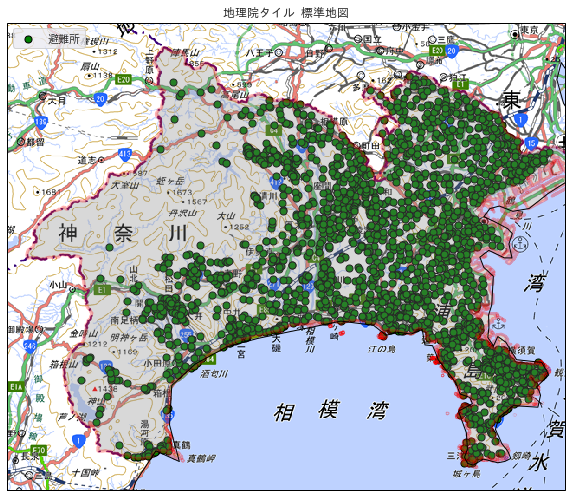

In [0]:
import numpy as np 
import matplotlib as mpl        
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import GoogleWTS
import six
from PIL import Image
import cartopy.io.shapereader as shpreader
%matplotlib inline

# 日本語フォントを設定
font = {'family':'IPAGothic'}
import seaborn as sns
sns.set(font='IPAGothic')

# https://github.com/SciTools/cartopy/issues/1341
# タイルサーバ取得のモンキパッチ
def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

# タイルサーバのURLを設定
class MyMap(GoogleWTS):
    # http://developer.mapquest.com/web/products/open/map for terms of use
    def _image_url(self, tile):
        x, y, z = tile
        url = 'https://cyberjapandata.gsi.go.jp/xyz/std/%s/%s/%s.png' % (z, x, y)
        return url
      
# タイルサーバに設定
cimgt.GoogleWTS.get_image = new_get_image
request = MyMap()

name = "地理院タイル 標準地図"
filename = "cyberjapan_std.svg"

# 描画領域の設定
extent = [138.884354, 139.771500, 35.705065, 35.099687]

# 表示サイズ
fig2 = plt.figure(figsize=(10, 10))

# 図法設定
ax = plt.axes(projection=request.crs)
ax.set_extent(extent)

# ShapeファイルをGoogleGoogleドライブから読み込み
f1 = 'drive/My Drive/Colab Notebooks/data/N03-190101_14_GML-m/N03-190101_14_GML-m.shp'
s1 = list(shpreader.Reader(f1).geometries())
ax.add_geometries(s1, ccrs.PlateCarree(), edgecolor='red', facecolor="gray", linewidth=3, alpha=0.3)

f2 = 'drive/My Drive/Colab Notebooks/data/P20-12_14_GML-u/P20-12_14_GML-u.shp'
points = list(shpreader.Reader(f2).geometries())

# タイトル設定
ax.set_title(name)

# ポイントデータ描画
ax.scatter([point.x for point in points],
           [point.y for point in points],
           transform=ccrs.Geodetic() , c='green',s=50, label='避難所', edgecolor='black', linewidth=1)

# 表示スタイル設定
ax.coastlines(resolution='10m')
ax.legend(loc='upper left')

# 表示
ax.add_image(request, 10)
plt.show()

# SVGデータに保存
fig2.savefig("drive/My Drive/Colab Notebooks/svg/" + filename, dpi=300, facecolor='None', edgecolor='None', transparent=True, format="svg")
